In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/signature_verification_dataset/sign_data" -d "/content/"

In [3]:
!cp -r "/content/drive/MyDrive/signature_verification_dataset/my_model.h5" -d "/content/"

In [4]:
import os
import sys
import math

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.preprocessing.image import ImageDataGenerator


In [7]:
train_df = pd.read_csv("/content/sign_data/train_data.csv")
test_df = pd.read_csv("/content/sign_data/test_data.csv")


In [8]:
train_df.columns =["img1","img2","similar"]
test_df.columns =["img1","img2","similar"]

In [9]:
train_df

,img1,img2,similar
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
...,...,...,...
23200,031/02_031.png,031/03_031.png,0
23201,031/02_031.png,031/12_031.png,0
23202,031/02_031.png,031/11_031.png,0
23203,031/02_031.png,031/06_031.png,0


In [10]:
train_df["img1"]

0        068/09_068.png
1        068/09_068.png
2        068/09_068.png
3        068/09_068.png
4        068/09_068.png
              ...      
23200    031/02_031.png
23201    031/02_031.png
23202    031/02_031.png
23203    031/02_031.png
23204    031/02_031.png
Name: img1, Length: 23205, dtype: object

In [11]:
print(len(train_df["img1"]))

23205


In [12]:
train_path = "/content/sign_data/train"
test_path = "/content/sign_data/test"

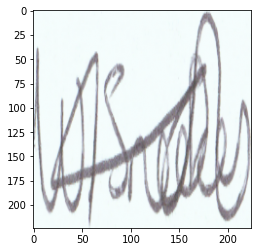

In [13]:
from skimage.io import imread, imshow
from skimage.transform import resize

imgr = imread(os.path.join(train_path,train_df["img1"][0]))
imgr=resize(imgr,(224,224,3))
plt.imshow(imgr)

In [14]:
from skimage.io import imread
from skimage.transform import resize


# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class TrainDataSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set1, x_set2, y_set, batch_size):
        self.x1, self.x2, self.y = x_set1, x_set2, y_set
        self.batch_size = batch_size
        self.train_path = "/content/sign_data/train"


    def __len__(self):
        return math.ceil(len(self.x1) / self.batch_size)

    def __getitem__(self, idx):
        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        X1 = []
        X2 = []
        for file_name1, file_name2 in zip(batch_x1, batch_x2):
                  f1 = resize(imread(os.path.join(self.train_path,file_name1)), (224, 224,3))
                  f2 = resize(imread(os.path.join(self.train_path,file_name2)), (224, 224,3))
                  X1.append(f1)
                  X2.append(f2)

        return [np.array(X1), np.array(X2)], np.array(batch_y)


In [15]:

class TestDataSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set1, x_set2, y_set, batch_size):
        self.x1, self.x2, self.y = x_set1, x_set2, y_set
        self.batch_size = batch_size
        self.test_path = "/content/sign_data/test"



    def __len__(self):
        return math.ceil(len(self.x1) / self.batch_size)

    def __getitem__(self, idx):
        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        X1 = []
        X2 = []
        for file_name1, file_name2 in zip(batch_x1, batch_x2):
                  f1 = resize(imread(os.path.join(self.test_path,file_name1)), (224, 224,3))
                  f2 = resize(imread(os.path.join(self.test_path,file_name2)), (224, 224,3))
                  X1.append(f1)
                  X2.append(f2)
        return [np.array(X1), np.array(X2)], np.array(batch_y)


In [16]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [17]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [19]:
def extractor_model(input_shape):

    vgg_16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg_16.trainable = False
    x = vgg_16.output
    x = Flatten(name="flatten")(x)
    output_layer = Dense(128, activation='relu')(x)
    model = Model(inputs=vgg_16.input, outputs=output_layer)
    
    return model

In [20]:
def create_model(input_shape):
  base_model = extractor_model(input_shape)
  print(base_model.summary())
  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)
  feat_1 = base_model(input_a)
  feat_2 = base_model(input_b)
  distance = Lambda(euclidean_distance)([feat_1, feat_2])
  outputs = Dense(1, activation="sigmoid")(distance)

  model = Model([input_a, input_b], outputs=outputs)
  return model

In [21]:
input_shape = (224, 224, 3)
optimzer = Adam(learning_rate=0.001)
BATCH_SIZE = 32

model = create_model(input_shape)
print(model.summary())

print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=optimzer, metrics=["accuracy"])


(224, 224, 3)
58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                

In [ ]:
train_sequence =  TrainDataSequence(train_df['img1'], train_df['img2'], train_df["similar"], batch_size = 32)
test_sequence =  TestDataSequence(test_df['img1'], test_df['img2'], test_df["similar"], batch_size = 32)


history = model.fit(train_sequence,validation_data = test_sequence, epochs = 5, verbose=1)

Epoch 1/5
726/726 [==============================] - 1263s 2s/step - loss: 1.3472 - accuracy: 0.5052 - val_loss: 0.8188 - val_accuracy: 0.5951
Epoch 2/5
726/726 [==============================] - 1258s 2s/step - loss: 0.6165 - accuracy: 0.6671 - val_loss: 0.3810 - val_accuracy: 0.8251
Epoch 3/5
726/726 [==============================] - 1259s 2s/step - loss: 0.3357 - accuracy: 0.8906 - val_loss: 0.2437 - val_accuracy: 0.9617
Epoch 4/5
726/726 [==============================] - 1262s 2s/step - loss: 0.2268 - accuracy: 0.9743 - val_loss: 0.1763 - val_accuracy: 0.9911
Epoch 5/5
726/726 [==============================] - 1273s 2s/step - loss: 0.1647 - accuracy: 0.9916 - val_loss: 0.1301 - val_accuracy: 0.9977


In [ ]:
model.save('signature_verification_Siamese.h5')

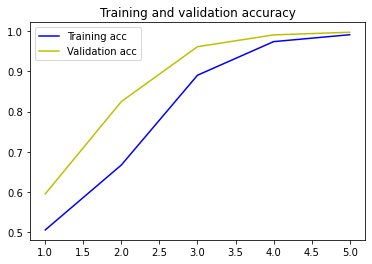

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig("accuracy3.jpg")
plt.show()

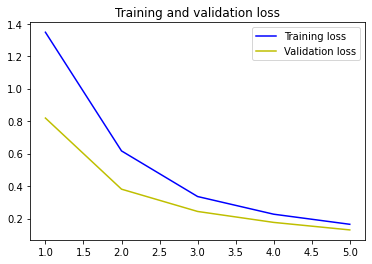

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("loss.jpg")

plt.show()